In [1]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import numpy as np
from sklearn.cluster import KMeans
import cv2

In [2]:
imagePath = 'assets_images_maps_North America_USA_Nelson Ledges_Nelson-Ledges04.png'

In [3]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(imagePath)

# Convert the image to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the red color range in HSV
# Red can appear in two ranges in the HSV spectrum, so we use two masks
lower_red1 = np.array([0, 30, 70])   # Lower range of red
upper_red1 = np.array([10, 255, 255]) # Upper range of red

lower_red2 = np.array([170, 30, 70]) # Second range of red
upper_red2 = np.array([180, 255, 255]) 

# Create masks for both red ranges
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine both masks
mask = mask1 + mask2

kernel = np.ones((3, 3), np.uint8) 

# dilate the image 
dilation = cv2.dilate(mask, kernel, iterations=1) 


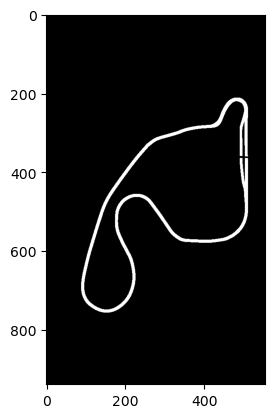

In [4]:
plt.imshow(dilation,cmap='gray')

In [5]:
plt.imsave('binary_image_png.png', dilation)

Binary image overlapping to match

In [6]:
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import numpy as np
from sklearn.cluster import KMeans
import cv2

In [7]:
def geotiff_resize( path, scale):
    with rasterio.open(path) as b:
        geotiff = b.read()

    geotiff =geotiff.reshape(geotiff.shape[1],geotiff.shape[2])
    geotiff_normalized = cv2.normalize(geotiff, None, 0, 255, cv2.NORM_MINMAX)
    geotiff_uint8 = geotiff_normalized.astype(np.uint8)

    scale_percent = scale  # Adjust as needed

    width = int(geotiff.shape[1] * scale_percent )
    height = int(geotiff.shape[0] * scale_percent )

    dim = (width, height)

    geotiff = cv2.resize(geotiff_uint8, dim, interpolation=cv2.INTER_NEAREST_EXACT)

    return geotiff

In [8]:
def bounded_image(png_path):

    png_image = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
    _, png_binary = cv2.threshold(png_image, 127, 255, cv2.THRESH_BINARY)

    non_zero_coords = cv2.findNonZero(png_binary)
    x, y, w, h = cv2.boundingRect(non_zero_coords)
    cropped_image = png_binary[y:y+h, x:x+w]

    return cropped_image


In [24]:
def get_accuracy(scaled_image, i_list, j_list,geotiff):
    original_h, original_w = scaled_image.shape[:2]
    desired_h, desired_w = geotiff.shape[:2]
    
    added_w = desired_w - original_w
    added_h = desired_h - original_h
    best_i, best_j, best_accuracy = -1, -1, 0  # Initialize variables

    for i in i_list:
        for j in j_list:
            top_padding = i
            bottom_padding = added_h - i
            left_padding = j
            right_padding = added_w - j


            padded_image = cv2.copyMakeBorder(
                scaled_image,
                top_padding,
                bottom_padding,
                left_padding,
                right_padding,
                cv2.BORDER_CONSTANT,
                value=0  # This adds black padding (pixel value 0)
            )

            geotiff_new = geotiff
            overlap_zeros = np.logical_and(padded_image == 255, geotiff_new == 255).astype(np.uint8)
            total_pixels = np.sum(padded_image == 255)

            if total_pixels == 0:
                continue  # Avoid division by zero if no 255 pixels are present

            correct_pixels = np.sum(overlap_zeros == 1)
            accuracy = (correct_pixels / total_pixels) * 100

            # Track the best accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_i = i
                best_j = j

    return best_i, best_j, best_accuracy


In [25]:
def get_results_initial(geotiff, cropped_image, min_scale, scale_step):
    best_i = 0
    best_j = 0
    best_accuracy = 0
    best_scale = 0
    best_rotation = 0 

    for rotation in [-1, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE]:
        print('for', rotation)

        if rotation == -1:
            rotated_image = cropped_image
        else:
            rotated_image = cv2.rotate(cropped_image, rotation)

        max_scale = geotiff.shape[0] / rotated_image.shape[0]

        for scale_png in np.arange(min_scale, max_scale, scale_step):
            scaled_image = cv2.resize(rotated_image, None, fx=scale_png, fy=scale_png, interpolation=cv2.INTER_NEAREST_EXACT)
            _, scaled_image = cv2.threshold(scaled_image, 127, 255, cv2.THRESH_BINARY)

            original_h, original_w = scaled_image.shape[:2]
            desired_h, desired_w = geotiff.shape[:2]
            added_w = desired_w - original_w
            added_h = desired_h - original_h

            i, j, accuracy = get_accuracy(scaled_image, range(added_h), range(added_w),geotiff)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_i = i
                best_j = j
                best_scale = scale_png
                best_rotation = rotation

    return best_accuracy, best_i, best_j, best_scale, best_rotation


In [26]:
def get_padded_image(best_i,best_j,best_scale,best_rotation,cropped_image,geotiff):

    scale_png = best_scale

    if best_rotation == -1:
        rotated_image = cropped_image
    else:
        rotated_image = cv2.rotate(cropped_image, best_rotation)
    
    scaled_image = cv2.resize(rotated_image, None, fx=scale_png, fy=scale_png, interpolation=cv2.INTER_NEAREST_EXACT)
    _, scaled_image = cv2.threshold(scaled_image, 127, 255, cv2.THRESH_BINARY)

    original_h, original_w = scaled_image.shape[:2]

    desired_h , desired_w = geotiff.shape[:2]

    added_w = desired_w - original_w
    added_h = desired_h - original_h

    top_padding = best_i
    bottom_padding = added_h-best_i
    left_padding = best_j
    right_padding = added_w-best_j


    padded_image = cv2.copyMakeBorder(
        scaled_image,
        top_padding,
        bottom_padding,
        left_padding,
        right_padding,
        cv2.BORDER_CONSTANT,
        value=0  # This adds black padding (pixel value 0)
    )

    geotiff_new=geotiff
    overlap_zeros = np.logical_and(padded_image == 255, geotiff_new == 255).astype(np.uint8)
    total_pixels = np.sum(padded_image == 255)
    correct_pixels = np.sum(overlap_zeros ==1)
    accuracy = (correct_pixels / total_pixels) * 100
    return padded_image,overlap_zeros

In [27]:
def overlap_binary(geotiff, padded_image):
    query_img = geotiff  
    train_img = padded_image 


    plt.figure(figsize=(10, 10))


    plt.imshow(query_img, cmap='Reds', alpha=0.5)

    plt.imshow(train_img, cmap='Blues', alpha=0.5)

    plt.title('Overlapping Binary Images')
    plt.show()

In [28]:
def get_results_final(cropped_image, i_list, j_list, scale_list, best_rotation,geotiff):
    
    
    best_i = 0
    best_j = 0
    best_accuracy = 0
    best_scale = 0
    for scale_png in scale_list:
        print('for scale',scale_png)
        
        if best_rotation == -1:
            rotated_image = cropped_image
        else:
            rotated_image = cv2.rotate(cropped_image, best_rotation)

        scaled_image = cv2.resize(rotated_image, None, fx=scale_png, fy=scale_png, interpolation=cv2.INTER_NEAREST_EXACT)
        _, scaled_image = cv2.threshold(scaled_image, 127, 255, cv2.THRESH_BINARY)

        
        i, j, accuracy = get_accuracy(scaled_image, i_list, j_list,geotiff)


        if accuracy>best_accuracy:
            best_accuracy=accuracy
            best_i=i
            best_j=j
            best_scale = scale_png

    return best_accuracy, best_i, best_j, best_scale

In [29]:
scale_percent = 0.05
geotiff = geotiff_resize('binary_output_blur.tif',scale=scale_percent)
cropped_image = bounded_image('binary_image_png.png')
best_accuracy, best_i, best_j, best_scale, best_rotation = get_results_initial(geotiff,cropped_image,0.2 ,0.003)
padded_image,_ = get_padded_image(best_i, best_j, best_scale, best_rotation,cropped_image,geotiff)
# 

for -1
for 1
for 0
for 2


In [34]:
new_scale = 1/scale_percent
required_i = int(best_i* new_scale)
required_j = int(best_j* new_scale)
required_scale = best_scale* new_scale

In [36]:
distance = 10
vary_scale = 0.1
scale_interval = 0.008
i_list = np.arange(required_i-int(distance/2), required_i+int(distance/2),1)
j_list =  np.arange(required_j-int(distance/2),required_j+int(distance/2),1)
scale_list = np.arange(required_scale- vary_scale/2, required_scale+vary_scale/2,scale_interval)

In [37]:
scale = 1
geotiff = geotiff_resize('binary_output_blur.tif',scale)
best_accuracy, best_i, best_j, best_scale= get_results_final(cropped_image, i_list, j_list, scale_list, best_rotation,geotiff)

for scale 4.250000000000001
for scale 4.258000000000001
for scale 4.266000000000001
for scale 4.274000000000001
for scale 4.282000000000001
for scale 4.290000000000001
for scale 4.298000000000001
for scale 4.306000000000001
for scale 4.314000000000001
for scale 4.322000000000001
for scale 4.330000000000001
for scale 4.338000000000001
for scale 4.346000000000001


In [38]:
best_accuracy, best_i, best_j, best_scale

(64.22942105972056, 364, 1219, 4.298000000000001)

In [39]:

padded_image,overlap_zeros = get_padded_image(best_i, best_j, best_scale, best_rotation,cropped_image,geotiff)

In [190]:
# kernel = np.ones((5, 5), np.uint8) 
# img_dilation = cv2.erode(padded_image, kernel, iterations=4) 
# plt.figure(figsize=(10,10))
# plt.imshow(img_dilation)
# overlap_zeros = overlap_zeros.astype(np.uint8)*255
# final_image = np.logical_or(img_dilation == 255, overlap_zeros == 255).astype(np.uint8)

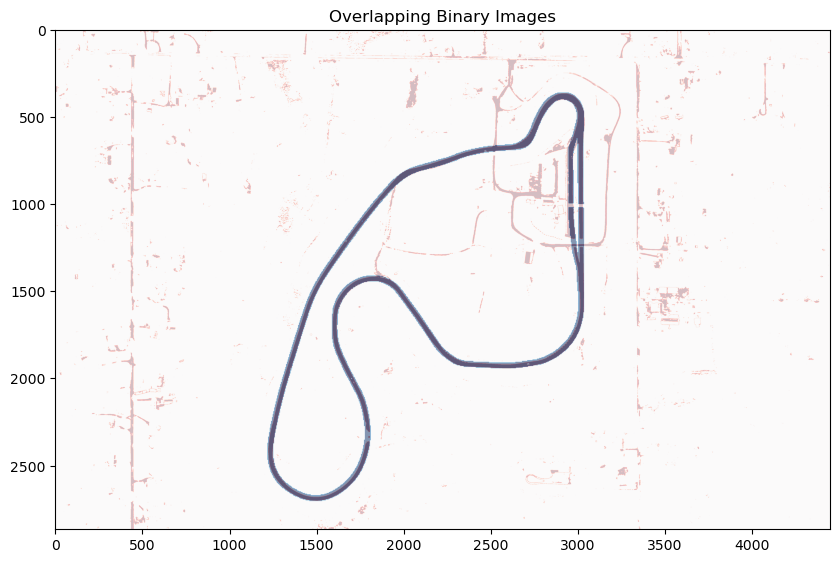

In [40]:
overlap_binary(geotiff,padded_image)

In [41]:
b = rasterio.open('binary_output_blur.tif')

(2866, 4448)

In [43]:
# Save the binary image as a new GeoTIFF file
with rasterio.open(
    'padded_image_blur.tif',
    'w',
    driver='GTiff',
    height=padded_image.shape[0],
    width=padded_image.shape[1],
    count=1,  # Single band for the binary image
    dtype=padded_image.dtype,
    crs=b.crs,
    transform=b.transform
) as dst:
    dst.write(padded_image, 1)

print("Binary image saved as 'padded_image_blur.tif'")


Binary image saved as 'padded_image_blur.tif'
